# Setup

In [83]:
import pandas as pd 
import numpy as np
import pickle 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras 
import tensorflow.python.platform.build_info as build
from database_connection import DBConn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

In [84]:
# check GPU availability 
print(f"TF is cuda build: {build.build_info['is_cuda_build']}")
print(f"Device list: {tf.config.list_physical_devices('GPU')}")

TF is cuda build: True
Device list: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [85]:
# globals 
TABLE = 'even_shot_data_table'
FEATURES = ['event_distance', 'event_angle', 'seconds_elapsed', 'game_period', 'x', 'y', 
            'is_home', 'score_down_4', 'score_down_3', 'score_down_2', 'score_down_1', 
            'score_up_4', 'score_up_3', 'score_up_2', 'score_up_1', 'score_even', 'wrist_shot', 
            'deflected_shot', 'tip_shot', 'slap_shot', 'backhand_shot', 'snap_shot', 
            'wrap_shot', 'state_5v5', 'state_4v4', 'state_3v3', 'goal']

# database connection 
db = DBConn()

In [86]:
# load the data in and check out a sample 
raw_df = db.query_with_copy(f'SELECT * FROM {TABLE}')
raw_df.head() 

,id,game_id,season,game_date,game_period,shot_event,seconds_elapsed,strength,strength_2,event_team,...,state_5v4,state_4v3,state_5v3,state_6v5,state_6v4,state_4v5,state_3v4,state_3v5,is_forward,off_wing
0,524157,2010020961,20102011,2011-03-03,2,SHOT,53,5x5,EV,BUF,...,0,0,0,0,0,0,0,0,1,0
1,524177,2010020961,20102011,2011-03-03,2,GOAL,612,5x5,EV,BUF,...,0,0,0,0,0,0,0,0,1,1
2,524179,2010020961,20102011,2011-03-03,2,MISS,702,5x5,EV,BUF,...,0,0,0,0,0,0,0,0,0,0
3,524260,2010020962,20102011,2011-03-03,1,MISS,496,5x5,EV,OTT,...,0,0,0,0,0,0,0,0,1,1
4,524285,2010020962,20102011,2011-03-03,1,SHOT,1160,5x5,EV,ATL,...,0,0,0,0,0,0,0,0,0,1


# Initial Exploration

In [87]:
raw_df.shape

(1273536, 83)

In [88]:
# check label distribution 
raw_df['goal'].value_counts()

goal
0    1196125
1      77411
Name: count, dtype: int64

In [89]:
# check that the shot_event and goal columns line up 
raw_df[raw_df['shot_event'] == 'GOAL'].shape

(77411, 83)

In [90]:
# check shot_event distribution 
raw_df['shot_event'].value_counts()

shot_event
SHOT    841932
MISS    354193
GOAL     77411
Name: count, dtype: int64

In [91]:
# look at null values 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(raw_df.isnull().sum())

id                       0
game_id                  0
season                   0
game_date                0
game_period              0
shot_event               0
seconds_elapsed          0
strength                 0
strength_2           30222
event_team               0
away_team                0
home_team                0
position                 0
shoots                   0
player1                  0
player2            1201377
player3            1216547
away_player1          4297
away_player2          6024
away_player3          5684
away_player4          6992
away_player5         13323
away_player6         48510
home_player1          4308
home_player2          5369
home_player3          6018
home_player4          7119
home_player5         13022
home_player6         47865
away_players             0
home_players             0
away_score               0
home_score               0
away_goalie          20004
home_goalie          18847
home_coach               0
away_coach               0
e

In [92]:
# make sure only even strength data is present  
raw_df['strength'].value_counts()

strength
5x5    1229507
4x4      35153
3x3       8876
Name: count, dtype: int64

In [93]:
raw_df = raw_df[raw_df['x'] >= 0]
raw_df.shape

(1246028, 83)

# Isolate Relevant Data

In [94]:
df = raw_df[FEATURES]
df.sample(10)

,event_distance,event_angle,seconds_elapsed,game_period,x,y,is_home,score_down_4,score_down_3,score_down_2,...,deflected_shot,tip_shot,slap_shot,backhand_shot,snap_shot,wrap_shot,state_5v5,state_4v4,state_3v3,goal
80988,89.000000,0.000000,565,2,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
737556,11.401754,15.255119,648,2,78,-3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
400797,9.219544,40.601295,947,3,82,-6,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0
67884,39.408121,35.706691,704,3,57,23,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1271811,51.855569,39.522631,1016,2,49,-33,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
602712,7.615773,23.198591,604,2,82,3,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
712981,49.244289,29.167613,252,2,46,24,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1202307,17.888544,26.565051,1109,2,73,-8,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1218848,68.095521,29.953608,389,2,30,34,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
482002,50.477718,33.690068,621,2,47,-28,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [95]:
df.isnull().sum()

event_distance     0
event_angle        0
seconds_elapsed    0
game_period        0
x                  0
y                  0
is_home            0
score_down_4       0
score_down_3       0
score_down_2       0
score_down_1       0
score_up_4         0
score_up_3         0
score_up_2         0
score_up_1         0
score_even         0
wrist_shot         0
deflected_shot     0
tip_shot           0
slap_shot          0
backhand_shot      0
snap_shot          0
wrap_shot          0
state_5v5          0
state_4v4          0
state_3v3          0
goal               0
dtype: int64

In [96]:
# check for outliers 
df.describe()

,event_distance,event_angle,seconds_elapsed,game_period,x,y,is_home,score_down_4,score_down_3,score_down_2,...,deflected_shot,tip_shot,slap_shot,backhand_shot,snap_shot,wrap_shot,state_5v5,state_4v4,state_3v3,goal
count,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,...,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06
mean,3.443428e+01,3.078886e+01,5.866330e+02,2.036551e+00,6.024249e+01,-1.296102e-01,5.124387e-01,2.119455e-02,3.745421e-02,9.026282e-02,...,2.020500e-02,5.848344e-02,1.804285e-01,8.051424e-02,1.412866e-01,1.170279e-02,9.650489e-01,2.789263e-02,7.058429e-03,6.095048e-02
std,1.812320e+01,2.021274e+01,3.486540e+02,8.542607e-01,1.785242e+01,1.919506e+01,4.998455e-01,1.440325e-01,1.898721e-01,2.865580e-01,...,1.407010e-01,2.346554e-01,3.845441e-01,2.720878e-01,3.483170e-01,1.075446e-01,1.836560e-01,1.646653e-01,8.371746e-02,2.392395e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.838478e+01,1.575117e+01,2.780000e+02,1.000000e+00,4.600000e+01,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.373426e+01,2.844293e+01,5.760000e+02,2.000000e+00,6.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.909175e+01,4.251045e+01,8.880000e+02,3.000000e+00,7.600000e+01,1.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.841240e+01,9.000000e+01,1.200000e+03,8.000000e+00,9.900000e+01,4.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [97]:
# re-check data characteristics
df.describe()

,event_distance,event_angle,seconds_elapsed,game_period,x,y,is_home,score_down_4,score_down_3,score_down_2,...,deflected_shot,tip_shot,slap_shot,backhand_shot,snap_shot,wrap_shot,state_5v5,state_4v4,state_3v3,goal
count,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,...,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06,1.246028e+06
mean,3.443428e+01,3.078886e+01,5.866330e+02,2.036551e+00,6.024249e+01,-1.296102e-01,5.124387e-01,2.119455e-02,3.745421e-02,9.026282e-02,...,2.020500e-02,5.848344e-02,1.804285e-01,8.051424e-02,1.412866e-01,1.170279e-02,9.650489e-01,2.789263e-02,7.058429e-03,6.095048e-02
std,1.812320e+01,2.021274e+01,3.486540e+02,8.542607e-01,1.785242e+01,1.919506e+01,4.998455e-01,1.440325e-01,1.898721e-01,2.865580e-01,...,1.407010e-01,2.346554e-01,3.845441e-01,2.720878e-01,3.483170e-01,1.075446e-01,1.836560e-01,1.646653e-01,8.371746e-02,2.392395e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-4.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.838478e+01,1.575117e+01,2.780000e+02,1.000000e+00,4.600000e+01,-1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.373426e+01,2.844293e+01,5.760000e+02,2.000000e+00,6.200000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.909175e+01,4.251045e+01,8.880000e+02,3.000000e+00,7.600000e+01,1.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.841240e+01,9.000000e+01,1.200000e+03,8.000000e+00,9.900000e+01,4.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [98]:
df['goal'].value_counts()

goal
0    1170082
1      75946
Name: count, dtype: int64

# Visualize Data Characteristics

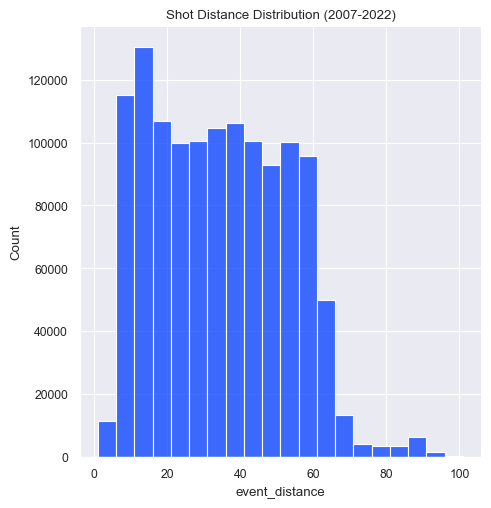

In [17]:
# full data shot distribution 
sns.set_theme(context = 'paper', style = 'darkgrid', palette = 'bright')
sns.displot(df, x = 'event_distance', binwidth = 5).set(title = 'Shot Distance Distribution (2007-2022)')

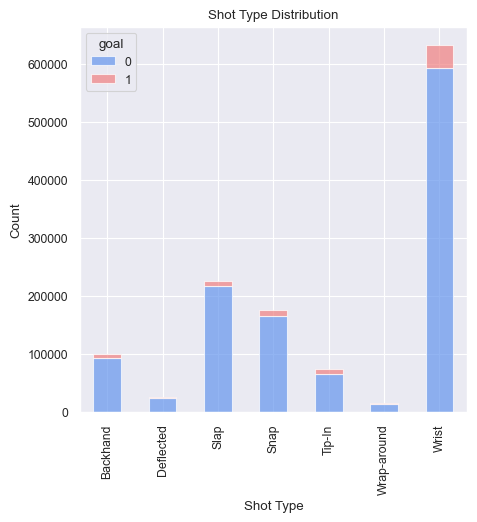

In [106]:
shot_type_goal_counts = raw_df.groupby('shot_type')['goal'].value_counts().unstack()
shot_type_goal_counts.plot(kind = 'bar', stacked = True, figsize = (5, 5), color = ['cornflowerblue', 'lightcoral'], alpha = 0.7)
plt.title('Shot Type Distribution')
plt.xlabel('Shot Type')
plt.ylabel('Count')
plt.show()

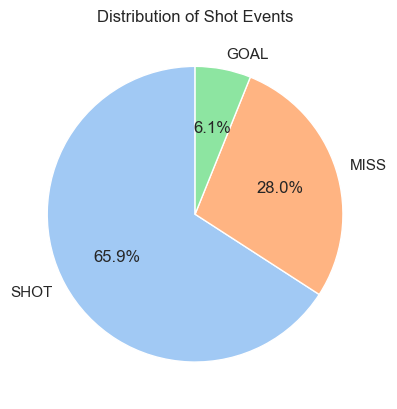

In [114]:
shot_counts = raw_df['shot_event'].value_counts()
colors = sns.color_palette('pastel')[0:3]
plt.pie(shot_counts, labels = shot_counts.index, colors = colors, autopct = '%1.1f%%', startangle = 90)
plt.title('Distribution of Shot Events')
plt.show()

# Dataset Preparation and Splitting

In [40]:
# using column transformer to only scale the non-binary features for the logistic regression model
ct = ColumnTransformer([
    ('ZeroToOneScaler', MinMaxScaler(), ['event_distance', 'event_angle', 'seconds_elapsed', 'x']),
    ('NegOneToOne', MinMaxScaler(feature_range = (-1, 1)), ['y'])
    ], remainder = 'passthrough'
)

In [34]:
# get x values 
x = df.drop('goal', axis = 1)
# get labels 
y = df['goal']

# split into train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 8, stratify = y)

# for the logistic regression model
x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.transform(x_test)

In [35]:
print(f'x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}\ny_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')
print(f'x_train_scaled shape: {x_train_scaled.shape}\nx_test_scaled shape: {x_test_scaled.shape}\n')

x_train shape: (996822, 26)
x_test shape: (249206, 26)
y_train shape: (996822,)
y_test shape: (249206,)
x_train_scaled shape: (996822, 26)
x_test_scaled shape: (249206, 26)



**Splits:**  
x_train shape: (996822, 26)  
x_test shape: (249206, 26)  
y_train shape: (996822,)  
y_test shape: (249206,)  
x_train_scaled shape: (996822, 26)  
x_test_scaled shape: (249206, 26)

# Logistic Regression  

Logistic regression is a relatively simple model, combined with our highly imbalanced dataset and the inherent complexity/randomness of goals in hockey, it is fair to assume this model will present a high bias and relatively low variance. This is a tell-tale sign of the model underfitting the true underlying function of the dataset relationship with the target label.  

In addition, logistic regression makes some underlying assumptions about the data such as observation independence and asssumes little to no multicollinearity among the independent variables. Our dataset mostly fails these assumptions so we don't expect a great model from this algorithm. 

## Training

In [42]:
# parameter search space 
c = [x for x in np.logspace(-5, 3, 100)]
max_iter = [500, 1000, 2000, 4000]

lg_param_grid = [
    {'C': c,
     'max_iter': max_iter}
]

In [43]:
lg = LogisticRegression(class_weight = 'balanced') 
lg_search = RandomizedSearchCV(estimator = lg, param_distributions = lg_param_grid, scoring = ['f1', 'accuracy'], refit = 'f1', verbose = 3, n_iter = 50, cv = 5, error_score = 'raise')
lg_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END C=0.4862601580065353, max_iter=4000; accuracy: (test=0.642) f1: (test=0.200) total time=   3.4s
[CV 2/5] END C=0.4862601580065353, max_iter=4000; accuracy: (test=0.642) f1: (test=0.200) total time=   3.6s
[CV 3/5] END C=0.4862601580065353, max_iter=4000; accuracy: (test=0.640) f1: (test=0.199) total time=   5.0s
[CV 4/5] END C=0.4862601580065353, max_iter=4000; accuracy: (test=0.643) f1: (test=0.201) total time=   4.3s
[CV 5/5] END C=0.4862601580065353, max_iter=4000; accuracy: (test=0.643) f1: (test=0.199) total time=   4.2s
[CV 1/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.630) f1: (test=0.193) total time=   1.0s
[CV 2/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.629) f1: (test=0.190) total time=   1.0s
[CV 3/5] END C=6.428073117284319e-05, max_iter=2000; accuracy: (test=0.627) f1: (test=0.190) total time=   1.0s
[CV 4/5] END C=6.428073117284319e-05, max_iter=2000; accu

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=LogisticRegression(class_weight='balanced'),
                   n_iter=50,
                   param_distributions=[{'C': [1e-05, 1.2045035402587812e-05,
                                               1.4508287784959402e-05,
                                               1.747528400007683e-05,
                                               2.104904144512022e-05,
                                               2.5353644939701114e-05,
                                               3.053855508833412e-05,
                                               3.678379771828634e-05,
                                               4.430621457583878e-05,
                                               5.3366992312063123e-05,
                                               6.42807...
                                               0.0002848035868435802,
                                               0.0003430469286314919,
                                               0.00041320124001153384,
                                               0.0004977023564332114,
                                               0.0005994842503189409,
                                               0.0007220809018385471,
                                               0.0008697490026177834,
                                               0.001047615752789665,
                                               0.0012618568830660211,
                                               0.0015199110829529348,
                                               0.0018307382802953698,
                                               0.0022051307399030455, ...],
                                         'max_iter': [500, 1000, 2000, 4000]}],
                   refit='f1', scoring=['f1', 'accuracy'], verbose=3)

In [44]:
# best values
print(lg_search.best_params_)
print(lg_search.best_score_)

{'max_iter': 2000, 'C': 0.0031992671377973846}
0.20200902942508972


In [56]:
# save the best model 
lg_model = lg_search.best_estimator_
print(lg_model)

with open('models/lg_model_even.pkl', 'wb') as output: 
    pickle.dump(lg_model, output)

LogisticRegression(C=0.0031992671377973846, class_weight='balanced',
                   max_iter=2000)


## Predictions

In [57]:
# load logistic regression model 
with open('models/lg_model_even.pkl', 'rb') as input:
    lg_model = pickle.load(input)

In [63]:
# predictions 
lg_preds = lg_model.predict(x_test_scaled)
lg_probs = lg_model.predict_proba(x_test_scaled)

print(f'Confusion Matrix:\n{confusion_matrix(y_test, lg_preds)}\n')
print(f'Classification Report:\n{classification_report(y_test, lg_preds)}')

Confusion Matrix:
[[152068  81949]
 [  4251  10938]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78    234017
           1       0.12      0.72      0.20     15189

    accuracy                           0.65    249206
   macro avg       0.55      0.68      0.49    249206
weighted avg       0.92      0.65      0.74    249206



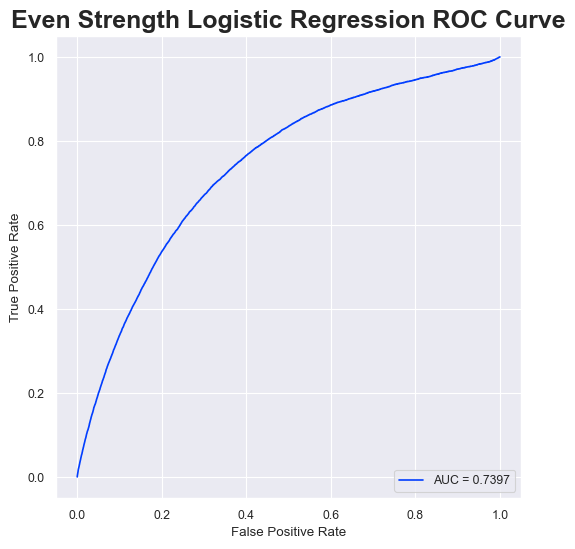

In [67]:
# plot roc curve
plt.figure(figsize = (6, 6))
lg_fpr, lg_tpr, _ = roc_curve(y_test, lg_probs[::,1])
lg_auc = round(roc_auc_score(y_test, lg_probs[::,1]), 4)
plt.plot(lg_fpr, lg_tpr, label = f'AUC = {lg_auc}')
plt.title('Even Strength Logistic Regression ROC Curve', fontdict = {'fontsize': 18, 'fontweight': 'bold'})
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')

As expected, our results are not great. Let's walk through the evaluation metrics:  

The **AUC** number represents how well our model separates between the two classes. An AUC of 0.5 generally suggests that the classifier is performing no better than random chance. Our raw AUC value suggests that the model does a somewhat reasonable job at separating the classes. There is the caveat that our dataset is very imbalanced, meaning that the AUC number is likely dominated by the majority (in this case the negative) class and is overly optimistic. With the imbalance of our dataset in mind, we know that the ROC curve here is somewhat deceiving because in these cases the false positive rate does not drop significantly when our total real negatives dominate the dataset.  

The **F1 score** is generally a better evaluation metric when it comes to imbalanced data. The F1 score represents the harmonic mean between the model's precision and recall. The logistic regression f1 scores (and the lack of improvement during the cross validation process) indicates that logistic regression is too simple of a model to capture the underlying function of our problem. 

# Random Forest Classifier

In [117]:
# parameter search space 
rf_param_grid = {
    'n_estimators': [5, 10, 50, 100, 150, 200],
    'max_depth': [4, 6, 8, 10, 15, None],
    'min_samples_split': [2, 3, 4, 5]
}

In [118]:
rf = RandomForestClassifier(class_weight = 'balanced') 
rf_search = RandomizedSearchCV(estimator = rf, scoring = 'f1', param_distributions = rf_param_grid, cv = 5, n_iter = 50, error_score = 'raise', verbose = 3)
rf_search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END max_depth=4, min_samples_split=4, n_estimators=10;, score=0.186 total time=   2.7s
[CV 2/5] END max_depth=4, min_samples_split=4, n_estimators=10;, score=0.186 total time=   2.7s
[CV 3/5] END max_depth=4, min_samples_split=4, n_estimators=10;, score=0.189 total time=   2.7s
[CV 4/5] END max_depth=4, min_samples_split=4, n_estimators=10;, score=0.192 total time=   2.5s
[CV 5/5] END max_depth=4, min_samples_split=4, n_estimators=10;, score=0.186 total time=   2.9s
[CV 1/5] END max_depth=8, min_samples_split=3, n_estimators=50;, score=0.203 total time=  21.2s
[CV 2/5] END max_depth=8, min_samples_split=3, n_estimators=50;, score=0.204 total time=  21.8s
[CV 3/5] END max_depth=8, min_samples_split=3, n_estimators=50;, score=0.201 total time=  22.3s
[CV 4/5] END max_depth=8, min_samples_split=3, n_estimators=50;, score=0.204 total time=  21.8s
[CV 5/5] END max_depth=8, min_samples_split=3, n_estimators=50;, score=0.2

KeyboardInterrupt: 